<a href="https://colab.research.google.com/github/Malvi-M/Semantic-Image-Segmentation-on-Urban-Streets/blob/main/ResNet_FCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Data Loading and Preprocessing**

Image segmentation can be interpreted as a classification problem, where the task is to classify each pixel of the image into a particular class. To build an end-to-end pixel-to-pixel segmentation network, our model must be capable of extracting rich spatial information from the images. A typical CNN used for classification takes an image as input, passes it through a series of convolutional and pooling layers and uses fully-connected layers in the end to output a fixed length vector, thus discarding all the spatial information from the original image. For building our model, we have used the `cityscapes-image-pairs` dataset, containing 2975 images which are used for training and 500 images for validating the performance of our model.

**Importing the required libraries**



*   Numpy - for linear algebra
*   os - for receiving information about files
*   matplotlib - for visualizing
*   PIL and CV2 - for image loading and editing
*   scikit-learn KMeans - for color clustering
*   random - for generating random numbers and choices
*   keras - a high level interface to tensorflow (for neural networks)


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plot
from PIL import Image
import cv2
import random
import seaborn as sns
from sklearn.cluster import KMeans


In [ ]:
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Conv2D, Activation, Add, Conv2DTranspose
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
import keras.metrics


Using TensorFlow backend.


After importing the libraries, we initialize all the necessary variables - 
* `train_folder` - Path for training images
* `valid_folder` - Path for testing images
* `width` - Width of an image
* `height` - Height of an image
* `classes` - No. of discrete pixel values in the segmentation maps (no. of labels)
* `batch_size` - Size of a single batch
* `num_of_training_samples` - Total number of training samples
* `num_of_testing_samples` - Total number of testing samples

In [ ]:
train_folder="/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/train"
valid_folder="/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val"
width = 256
height = 256
classes = 13
batch_size = 10
num_of_training_samples = len(os.listdir(train_folder)) 
num_of_testing_samples = len(os.listdir(valid_folder))

## **Helper Functions**


---


For preprocessing the dataset and defining the model, we have defined several helper functions -


* `LoadImage` - Loads a single image and its corresponding segmentation map, also allows simple Data Augmentation options such as flipping and rotating 
    * **Arguements** :
        * `name` - Name of the image file
        * `path` - Path to the image directory
        * `rotation` - Angle by which the image will rotate for Data Augmentation
        * `flip` - True/False
        * `size` - size of image
    * **Returns** - A tuple of 2 numpy arrays (image and segmentation map)



---


* `ColorToClass` - Converts the discrete color representation (output of the color clustering) to a 13-dimensional class representation used for training our model
    * **Arguements** :
        * `seg` - Segmentation mask after clustering (width, height, 3) **(RGB)**
    * **Returns** - Categorical segmentation map (width, height, classes) 



---


* `LayersToRGBImage` - Converts the layer representation (categorical arrays) to a color representation for visualization 
    * **Arguements** :
        * `img` - Categorical segmented map (height, width, 13)
    * **Returns** - Colored segmentation map (width, height, 3) **(RGB)**


---


* `DataGenerator` - creates batches of e.g. 10 raw-segmented image pairs at a time, also uses image augmentation and randomly flips and rotates the images to increase the effective size of the dataset and returns data in form of batches  
    * **Arguements** :
        * `path` - location or path of the image directory
        * `batch_size` - size of each batch
        * `maxangle` -  angle to rotate image
    * **Returns** - Tuple of `batch_size` number of images and segmentation maps


---







* `fcn` - Creates the FCN model
    * **Arguements** :
        * `vgg` - VGG16 pretrained model
        * `classes` - Number of categories or unique pixel values (13)
        * `fcn8` - Set True to use FCN-8s model
        * `fcn16` - Set True to use FCN-16s model
    * **Returns** - FCN model
    * **Note** - If both `fcn8` and `fcn16` arguements are set to False, it returns FCN-32s model by default




---










## Load Image and Segmentation Mask

In [ ]:
def LoadImage(name, path="/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/train",
             rotation=0.0, flip=False, size=(256, 256)):
    img = Image.open(path+"/"+name)
    img = np.array(img)
    seg = img[:, 256:]
    img = img[:, 0:256]
    
    for i in range(3):
        zimg = img[:,:,i]
        zimg = cv2.equalizeHist(zimg)
        img[:,:,i] = zimg
    
    img = Image.fromarray(img).resize(size)
    seg = Image.fromarray(seg).resize(size)

    img = img.rotate(rotation)
    seg = seg.rotate(rotation)

    img = np.array(img)
    seg = np.array(seg)

    if flip:
        img = img[:,::-1,:]
        seg = seg[:,::-1,:]

        #seg = np.round(seg/255.0)
    
    return img/255, seg/255

## Color Clustering

In [ ]:
files =os.listdir("/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/train")[0:10]

colors = []
for file in files:
    img, seg = LoadImage(file, "/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/train")
    colors.append(seg.reshape(seg.shape[0]*seg.shape[1], 3))
colors = np.array(colors)
colors = colors.reshape((colors.shape[0]*colors.shape[1],3))

km = KMeans(n_clusters=13)
km.fit(colors)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=13, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

## Colors to Class labels

In [ ]:
def ColorsToClass(seg):
    s = seg.reshape((seg.shape[0]*seg.shape[1],3))
    s = km.predict(s)
    s = s.reshape((seg.shape[0], seg.shape[1]))
    
    n = len(km.cluster_centers_)
    
    cls = np.zeros((seg.shape[0], seg.shape[1], n))
    
    for i in range(n):
        m = np.copy(s)
        m[m!=i] = 0
        m[m!=0] = 1
        
        cls[:,:,i]=m
        
    return cls

## Categorical arrays to Segmentation Masks

In [ ]:
def LayersToRGBImage(img):
    colors = [(255,0,0), (0,255,0), (0,0,255),
             (255,255,0), (255,0,255), (0,255,255),
             (255,255,255), (200,50,0),(50,200,0),
             (50,0,200), (200,200,50), (0,50,200),
             (0,200,50), (0,0,0)]
    
    nimg = np.zeros((img.shape[0], img.shape[1], 3))
    for i in range(img.shape[2]):
        c = img[:,:,i]
        col = colors[i]
        
        for j in range(3):
            nimg[:,:,j]+=col[j]*c
    nimg = nimg/255.0
    return nimg

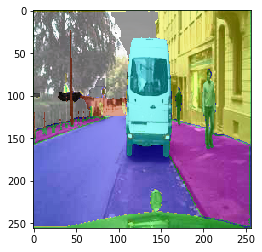

In [ ]:
img, seg = LoadImage("174.jpg")
seg2 = ColorsToClass(seg)
seg2 = LayersToRGBImage(seg2)
total = cv2.addWeighted(img, 0.6, seg2, 0.4, 0)
plot.imshow(total[:,:,:])
plot.show()

## Generator function to generate data batches

In [ ]:
def DataGenerator(path="/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/train", batch_size=10, maxangle=10.0):
    
    files = os.listdir(path)
    while True:
        imgs=[]
        segs=[]
        
        for i in range(batch_size):
            file = random.sample(files,1)[0]
            
            flip=False
            if random.random() > 0.5:
                flip=True
            
            angle = maxangle*(random.random()*2-1)
            
            img, seg = LoadImage(file, path, rotation=angle, flip=flip)
            
            seg = ColorsToClass(seg)
            
            imgs.append(img)
            segs.append(seg)
        yield np.array(imgs), np.array(segs)

## Visualize Data Samples

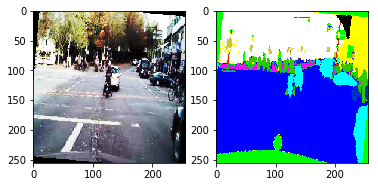

In [ ]:
gen = DataGenerator()
imgs, segs = next(gen)
# imgs.shape, segs.shape
plot.subplot(121)
plot.imshow(imgs[0])
plot.subplot(122)
plot.imshow(LayersToRGBImage(segs[0]))
plot.show()


## ResNet50 Encoder 

In [ ]:
model_1 = ResNet50(include_top=False,
    weights="imagenet",
    input_shape=(width, height, 3)
   )

/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 2s 0us/step


In [ ]:
model_1.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

## Segmentation model - FCN Architecture with ResNet50 encoder

In [ ]:
def fcn(resnet, classes = 13, fcn8 = False, fcn16 = False):
    pool5 = resnet.get_layer('activation_49').output
    pool4 = resnet.get_layer('activation_40').output
    pool3 = resnet.get_layer('activation_22').output
    
    conv_6 = Conv2D(1024, (7, 7), activation='relu', padding='same', name="conv_6")(pool5)
    conv_7 = Conv2D(1024, (1, 1), activation='relu', padding='same', name="conv_7")(conv_6)
    
    conv_8 = Conv2D(classes, (1, 1), activation='relu', padding='same', name="conv_8")(pool4)
    conv_9 = Conv2D(classes, (1, 1), activation='relu', padding='same', name="conv_9")(pool3)
    
    deconv_7 = Conv2DTranspose(classes, kernel_size=(2,2), strides=(2,2))(conv_7)
    add_1 = Add()([deconv_7, conv_8])
    deconv_8 = Conv2DTranspose(classes, kernel_size=(2,2), strides=(2,2))(add_1)
    add_2 = Add()([deconv_8, conv_9])
    deconv_9 = Conv2DTranspose(classes, kernel_size=(8,8), strides=(8,8))(add_2)
    
    if fcn8 :
        
        output_layer = Activation('softmax')(deconv_9)
    elif fcn16 :
        deconv_10 = Conv2DTranspose(classes, kernel_size=(16,16), strides=(16,16))(add_1)
        output_layer = Activation('softmax')(deconv_10)
    else:
        deconv_11 = Conv2DTranspose(classes, kernel_size=(32,32), strides=(32,32))(conv_7)
        output_layer = Activation('softmax')(deconv_11)
    
    
    model = Model(inputs=resnet.input, outputs=output_layer)
    return model

## Fully Convolutional Network

There has been a lot of research on using convolutional neural networks for image recognition, the task of predicting a single label for an entire image. Most recognition models consist of a series of convolutional and pooling layers followed by a fully-connected layer that maps from a 3D array to a 1D array of probabilities.

![Neural network architecture for recognition](https://2rct3i2488gxf9jvb1lqhek9-wpengine.netdna-ssl.com/wp-content/uploads/2017/05/cnn.png)

The FCN was originally proposed as an adaptation of the VGG recognition model, but can be used to adapt newer recognition models such as ResNets, which we used in our experiments. One advantage of the FCN over other architectures is that it is easy to initialize the bulk of the model using weights that were obtained from training on a large object recognition dataset such as ImageNet. This is often helpful when the size of the training set is small relative to the complexity of the model.

![Fully convolutional neural network architecture for semantic segmentation](https://2rct3i2488gxf9jvb1lqhek9-wpengine.netdna-ssl.com/wp-content/uploads/2017/05/fcn.png)



In [ ]:
model = fcn(model_1, fcn8=True)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

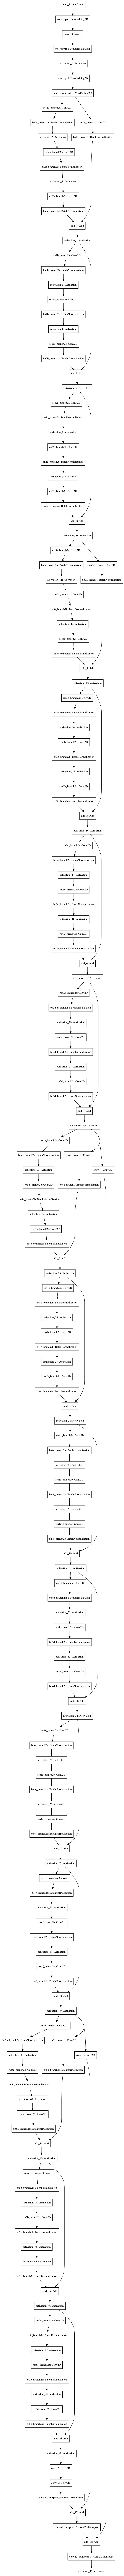

In [ ]:
plot_model(model)

## Train our model

In [ ]:
train_gen = DataGenerator()
val_gen = DataGenerator(valid_folder)

In [ ]:
adam = Adam(lr=0.0001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
filepath = "best-model-resnet50.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit_generator(train_gen, epochs=20, steps_per_epoch=num_of_training_samples//batch_size,
                       validation_data=val_gen, validation_steps=num_of_testing_samples//batch_size,
                       callbacks=callbacks_list, use_multiprocessing=True)

Epoch 1/20
297/297 [==============================] - 348s 1s/step - loss: 1.4151 - accuracy: 0.5141 - val_loss: 2.8354 - val_accuracy: 0.3553

Epoch 00001: val_accuracy improved from -inf to 0.35527, saving model to best-model-resnet50.hdf5
Epoch 2/20
297/297 [==============================] - 297s 1s/step - loss: 0.6585 - accuracy: 0.7705 - val_loss: 1.9273 - val_accuracy: 0.5036

Epoch 00002: val_accuracy improved from 0.35527 to 0.50360, saving model to best-model-resnet50.hdf5
Epoch 3/20
297/297 [==============================] - 294s 990ms/step - loss: 0.5773 - accuracy: 0.7873 - val_loss: 0.9405 - val_accuracy: 0.7265

Epoch 00003: val_accuracy improved from 0.50360 to 0.72646, saving model to best-model-resnet50.hdf5
Epoch 4/20
297/297 [==============================] - 300s 1s/step - loss: 0.5343 - accuracy: 0.7944 - val_loss: 0.4803 - val_accuracy: 0.7862

Epoch 00004: val_accuracy improved from 0.72646 to 0.78624, saving model to best-model-resnet50.hdf5
Epoch 5/20
297/297 [

In [ ]:
model.save("ResNet_model.h5")
model = load_model("ResNet_model.h5")

NameError: name 'load_model' is not defined

## Validation and Vizualization

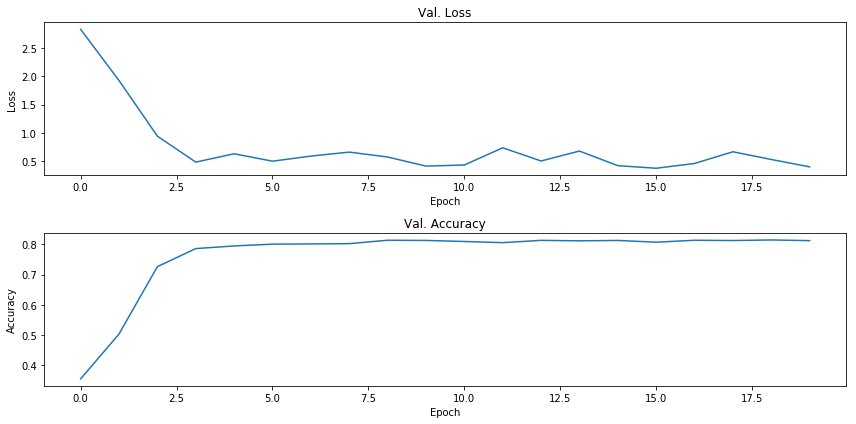

In [ ]:
loss = history.history["val_loss"]
acc = history.history["val_accuracy"] 

plot.figure(figsize=(12, 6))
plot.subplot(211)
plot.title("Val. Loss")
plot.plot(loss)
plot.xlabel("Epoch")
plot.ylabel("Loss")

plot.subplot(212)
plot.title("Val. Accuracy")
plot.plot(acc)
plot.xlabel("Epoch")
plot.ylabel("Accuracy")

plot.tight_layout()
plot.savefig("ResNet50_learn.png", dpi=150)
plot.show()

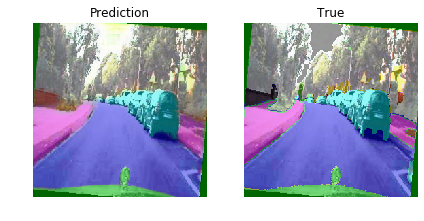

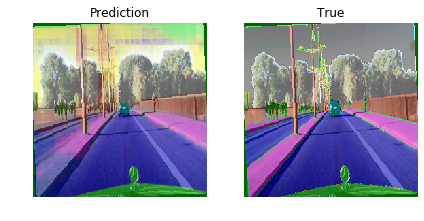

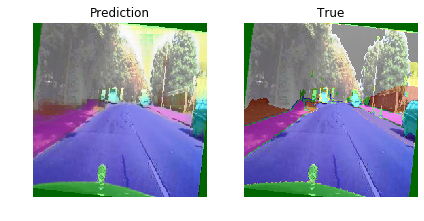

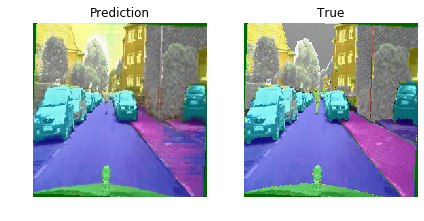

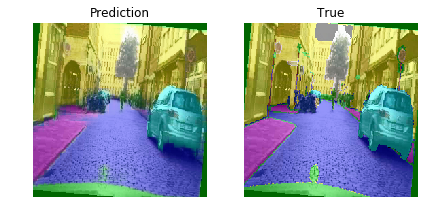

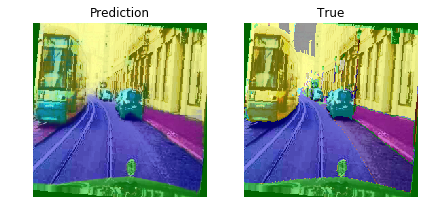

In [ ]:
test_gen = DataGenerator(valid_folder)
max_show=5
for imgs, segs in test_gen:
    p = model.predict(imgs)
    for i in range(p.shape[0]):
        if i > max_show:
            break
        _p = LayersToRGBImage(p[i])
        _s = LayersToRGBImage(segs[i])
        
        predimg = cv2.addWeighted(imgs[i], 0.6, _p, 0.4, 0)
        trueimg = cv2.addWeighted(imgs[i], 0.6, _s, 0.4, 0)
        plot.figure(figsize=(6,6))
        plot.subplot(121)
        plot.title("Prediction")
        plot.imshow(predimg)
        plot.axis("off")
        plot.subplot(122)
        plot.title("True")
        plot.imshow(trueimg)
        plot.axis("off")
        plot.tight_layout()
        plot.savefig("pred_"+str(i)+".png", dpi=150)
        plot.show()
    break

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


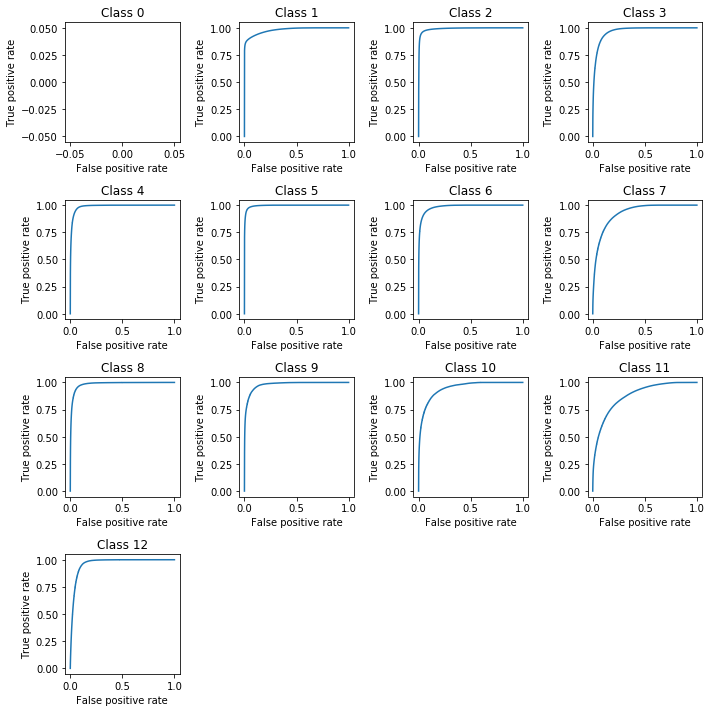

In [ ]:
from sklearn.metrics import roc_curve, balanced_accuracy_score
test_gen = DataGenerator(valid_folder, batch_size=200)
max_show=20

bass = []

for imgs, segs in test_gen:
    p = model.predict(imgs)
    
    plot.figure(figsize=(10, 10))
    for i in range(p.shape[-1]):
        fpr, tpr, _ = roc_curve(segs[:,:,:,i].ravel(), p[:,:,:,i].ravel())
        
        _p = np.round(p[:,:,:,i].ravel()).astype(np.int32)
        bas = balanced_accuracy_score(segs[:,:,:,i].ravel(), _p)
        
        bass.append(bas)
        
        plot.subplot(4,4,i+1)
        plot.plot(fpr, tpr)
        plot.title("Class "+str(i))
        plot.xlabel("False positive rate")
        plot.ylabel("True positive rate")
    
    plot.tight_layout()
    plot.show()
    
    break

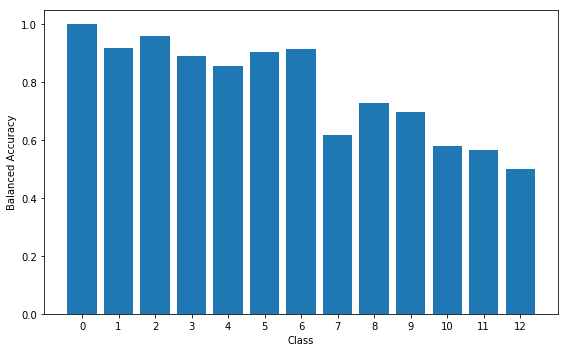

In [ ]:
plot.figure(figsize=(8, 5))
plot.bar(np.arange(0, len(bass)), bass)
plot.xticks(np.arange(0, len(bass)))
plot.ylabel("Balanced Accuracy")
plot.xlabel("Class")
plot.tight_layout()
plot.savefig("ResNet50_BalAcc.png")
plot.show()

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


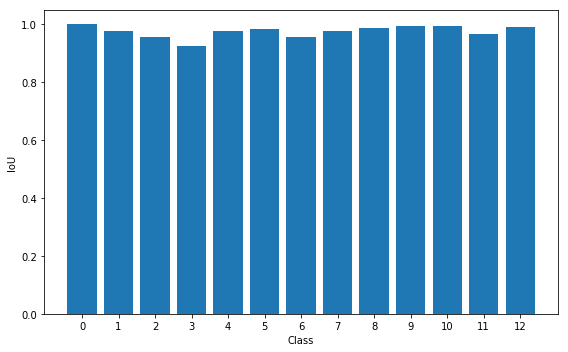

In [ ]:
from sklearn.metrics import jaccard_similarity_score 

test_gen = DataGenerator(valid_folder, batch_size=200)

for imgs, segs in test_gen:
  p = model.predict(imgs)  
  IoU = []
  for i in range(p.shape[-1]):
        
        _p = np.round(p[:,:,:,i].ravel()).astype(np.int32)
        iou = jaccard_similarity_score(segs[:,:,:,i].ravel(), _p)
        IoU.append(iou)
    
  break

plot.figure(figsize=(8, 5))
plot.bar(np.arange(0, len(IoU)), IoU)
plot.xticks(np.arange(0, len(IoU)))
plot.ylabel("IoU")
plot.xlabel("Class")
plot.tight_layout()
plot.savefig("ResNet50_mIoU.png")
plot.show()

## References

* [Fully Convolutional Networks for Semantic Segmentation](https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Long_Fully_Convolutional_Networks_2015_CVPR_paper.pdf)
* [Deep Learning for Semantic Segmentation of Aerial and Satellite Imagery](https://www.azavea.com/blog/2017/05/30/deep-learning-on-aerial-imagery/)
* [An Introduction to different Types of Convolutions in Deep Learning](https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d)